## Seminar 12. Reinforcement Learning. A2C and PPO




In [ ]:
!pip install gymnasium

In [ ]:
import sys, os

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

from dataclasses import dataclass
import typing as tt
from typing import List

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import gymnasium as gym

from IPython.display import clear_output

%matplotlib inline

Today, we conclude our overview of model-free RL methods.

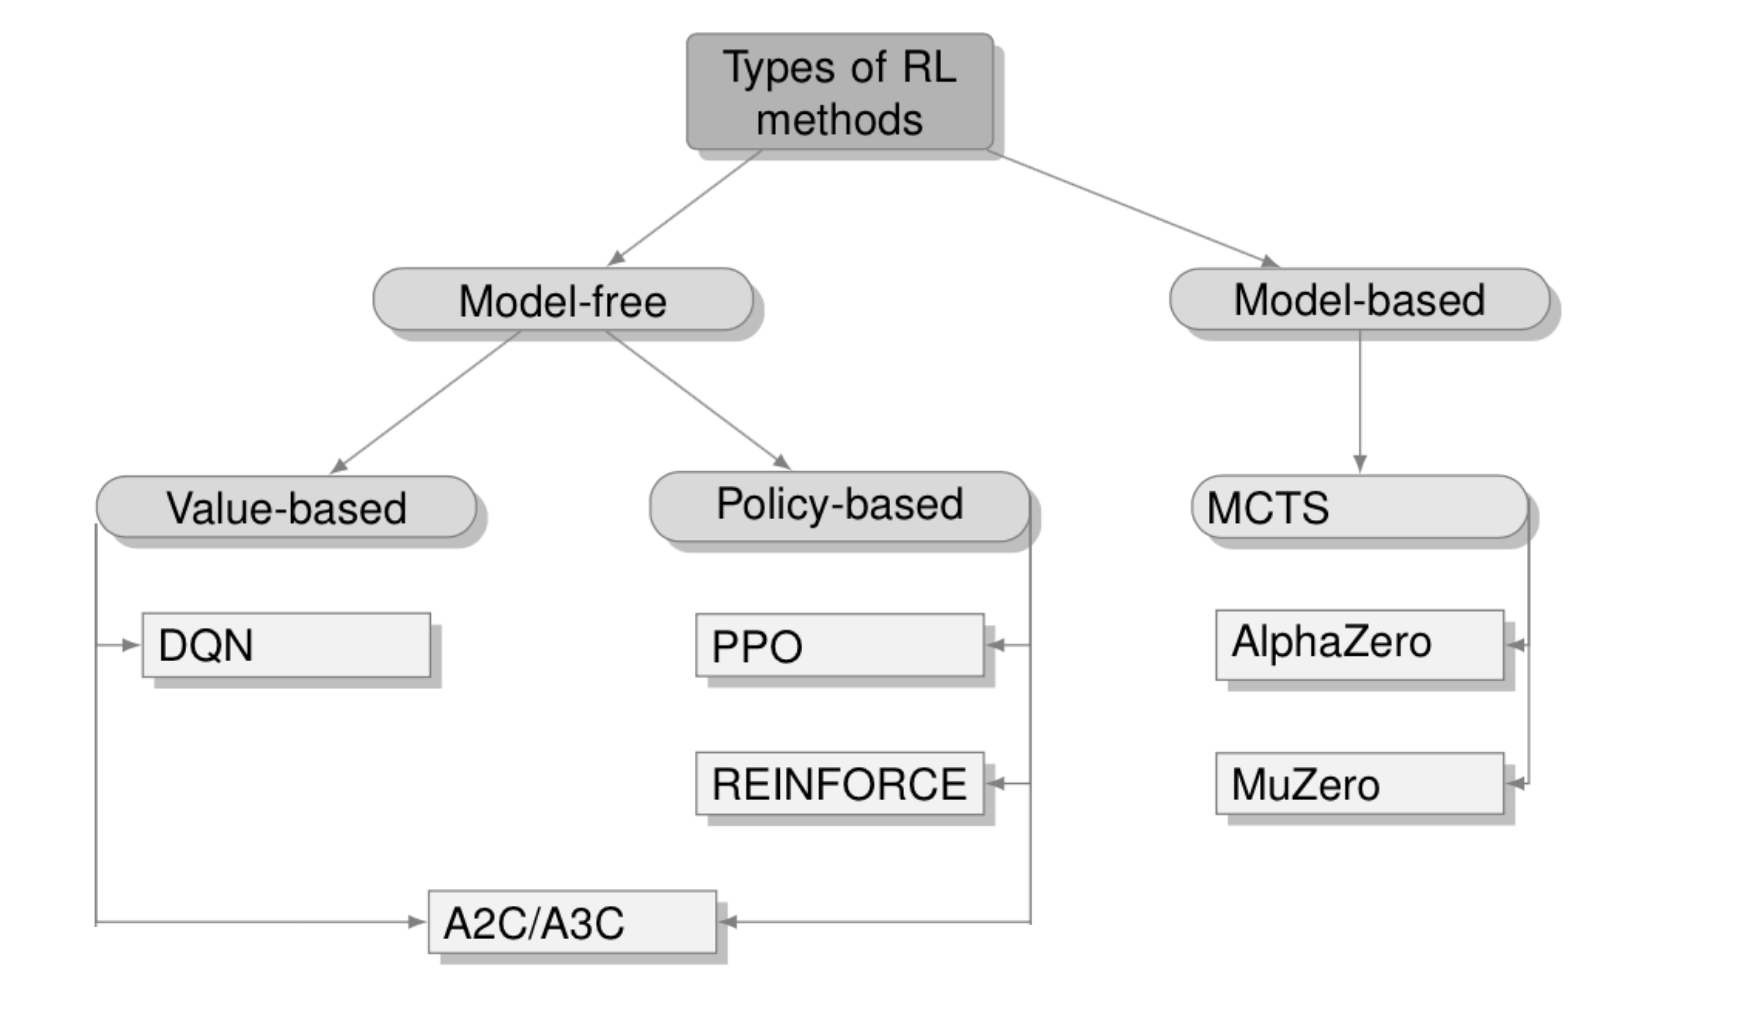

#  Proximal Policy Optimization (PPO)

Several other well-established RL methods exist. We will focus solely on **Proximal Policy Optimization** (PPO) due to its relative simplicity. For more details about Policy Gradient Methods see e.g. https://lilianweng.github.io/posts/2018-04-08-policy-gradient/

1. First, let’s denote the probability ratio between old and new policies as $$r(\theta) = \frac{\pi_\theta(a \vert s)}{\pi_{\theta_\text{old}}(a \vert s)}.$$ Then, the **new objective function** of PPO is: $$J^\text{PPO} (\theta) = \mathbb{E} [ r(\theta) \hat{A}_{\theta_\text{old}}(s, a) ].$$ However, if we just start to blindly maximize this value, it may lead to a very large update to the policy weights. To limit the update, the clipped objective is used. $$J^\text{CLIP} (\theta) = \mathbb{E} [ \min( r(\theta) \hat{A}_{\theta_\text{old}}(s, a), \text{clip}(r(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_{\theta_\text{old}}(s, a))].$$

2. Another difference from the A2C method is the way that we **estimate the advantage**. For A2C we used the formula   $$A_t = -V(s_t) +r_t +\gamma r_{t+1} + \dots + \gamma^{T-t+1}r_{T-1} + \gamma^{T-t} V(s_T).$$  In the PPO paper, the authors used a more general estimation $$A_t = \sigma_t + (\gamma \lambda) \sigma_{t+1}  + (\gamma \lambda)^2 \sigma_{t+1} + \dots + (\gamma \lambda)^{T-t+1} \sigma_{T-1},$$ where $$\sigma_t = r_t + \gamma V(s_{t+1} ) - V(s_t).$$




## Basic functions and constants

Import libraries

In [ ]:
import torch
import gymnasium as gym
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

Fix device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Constants (parameters of the agent)

In [ ]:
class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    learning_rate = 0.02
    k_epoch = 3
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01

    # Memory
    memory_size = 400

    train_cartpole = True

Function to plot the data

In [ ]:
def plot_graph(reward_history, avg_reward):
    df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
    plt.style.use('seaborn-v0_8-darkgrid')
    palette = plt.get_cmap('Set1')

    plt.plot(df['x'], df['Reward'], marker='', color=palette(1), linewidth=0.8, alpha=0.9, label='Reward')

    plt.title("CartPole", fontsize=14)
    plt.xlabel("episode", fontsize=12)
    plt.ylabel("score", fontsize=12)

    plt.savefig('score.png')

## 2.2 PPO model

NN for the policy

In [ ]:
class PPO_Policy(nn.Module):
    def __init__(self, action_size, input_size=4):
        super(PPO_Policy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def actor(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def critic(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x

The code below more or less combines the previous elements into a single module.

* `train` is a standard training loop.

The non-trivial parts are:

* `update_network`, where we calculate *the new loss*.
* `finish_path`, where we compute *the new advantages*.

Hints:

*. For `CartPole`, handle both terminated and truncated episodes (pole fell).

In [ ]:
class Agent(AgentConfig):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.action_size = self.env.action_space.n  # 2 for cartpole
        if self.train_cartpole:
            self.policy_network = PPO_Policy(action_size=self.action_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)

        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        screen, reward, terminal, info, _ = self.env.step(action)
        return screen, reward, action, terminal

    def train(self):
        episode = 0
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        # A new episode
        while not solved:
            start_step = step
            episode += 1
            episode_length = 0

            # Get initial state
            state, reward, action, terminal = self.new_random_game()
            current_state = state
            total_episode_reward = 1

            # A step in an episode
            while not solved:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.actor(torch.FloatTensor(current_state).to(device))
                action = torch.distributions.Categorical(prob_a).sample().item()

                # Act
                state, reward, terminal, trunc, _ = self.env.step(action)
                terminal = terminal or trunc # !!! TRUNCATED episodes are over
                new_state = state

                reward = -1 if terminal else reward

                self.add_memory(current_state, action, reward/10.0, new_state, terminal, prob_a[action].item())

                current_state = new_state
                total_episode_reward += reward

                if terminal:
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    avg_reward.append(sum(reward_history[-10:])/10.0)

                    self.finish_path(episode_length)

                    # STOP if solved
                    if len(reward_history) > 100 and sum(reward_history[-100:-1]) / 100 >= 475:
                        solved = True

                    if episode % 25 == 0:
                        print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                          'loss: %.4f' % (episode, step, episode_length, total_episode_reward,
                                                    self.loss))



                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

            if episode % self.plot_every == 0:
                plot_graph(reward_history, avg_reward)

        self.env.close()

    def update_network(self):
        '''
        Here we calculate the new PPO loss:
        clipped E[ \pi \ pi_old * \hat{A}_{old}(s, a) ]
        '''
        # get ratio
        pi = self.policy_network.actor(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']))
        old_probs_a = torch.FloatTensor(self.memory['action_prob'])
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.FloatTensor(self.memory['advantage'])
        # clip
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage'])

        # critic loss
        pred_v = self.policy_network.critic(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - self.memory['td_target']).pow(2)  # Huber loss

        # entropy loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy])

        # total loss
        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        '''
        New advantage:
        A_t = \sigma_t + \dots + (\gamma \lambda)^{T-t+1} \sigma_{T-1},
        where \sigma_t = r_t + \gamma V(s_{t+1}) - V(s_t).
        '''

        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = torch.FloatTensor(reward) + \
                    self.gamma * self.policy_network.critic(torch.FloatTensor(next_state)) * \
                    torch.FloatTensor(terminal)
        delta = td_target - self.policy_network.critic(torch.FloatTensor(state))
        delta = delta.detach().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'], td_target.data), dim=0)
        self.memory['advantage'] += advantages


Main task.

Current behavior (not ideal): If training failures / stops, restart it manually.

In [ ]:
agent = Agent()
agent.train()